In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\New\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Reading in data
# ==============================================================================
building3=pd.read_csv('Building 3.csv')

In [5]:
#Converting to Datetime objects
# ==============================================================================
building3['datetime']=pd.to_datetime(building3['datetime'], format='%Y-%m-%d %H:%M:%S')
building3= building3.set_index('datetime')
building3= building3.asfreq('H')

In [6]:
building3

Unnamed: 0  series_value    Year  Month  Day_of_Month  \
datetime                                                                     
2016-03-01 05:00:00         3.0        1321.0  2016.0    3.0           1.0   
2016-03-01 06:00:00         7.0        1293.0  2016.0    3.0           1.0   
2016-03-01 07:00:00        11.0        1249.0  2016.0    3.0           1.0   
2016-03-01 08:00:00        15.0        1125.0  2016.0    3.0           1.0   
2016-03-01 09:00:00        19.0         693.0  2016.0    3.0           1.0   
...                         ...           ...     ...    ...           ...   
2020-10-31 19:00:00    163739.0         243.0  2020.0   10.0          31.0   
2020-10-31 20:00:00    163743.0         245.0  2020.0   10.0          31.0   
2020-10-31 21:00:00    163747.0         341.0  2020.0   10.0          31.0   
2020-10-31 22:00:00    163751.0         320.0  2020.0   10.0          31.0   
2020-10-31 23:00:00    163755.0         322.0  2020.0   10.0          31.0   

                     Hour  minutes series_name  
datetime                                        
2016-03-01 05:00:00   5.0      0.0   Building3  
2016-03-01 06:00:00   6.0      0.0   Building3  
2016-03-01 07:00:00   7.0      0.0   Building3  
2016-03-01 08:00:00   8.0      0.0   Building3  
2016-03-01 09:00:00   9.0      0.0   Building3  
...                   ...      ...         ...  
2020-10-31 19:00:00  19.0      0.0   Building3  
2020-10-31 20:00:00  20.0      0.0   Building3  
2020-10-31 21:00:00  21.0      0.0   Building3  
2020-10-31 22:00:00  22.0      0.0   Building3  
2020-10-31 23:00:00  23.0      0.0   Building3  

[40939 rows x 8 columns]

In [7]:
#Split Train-Val for Building3
# ==============================================================================
end_train='2018-12-31 23:00'
start_val='2019-01-01 00:00'
end_val='2019-12-31 23:00'
start_test='2020-01-01 00:00'

building3train=building3.loc[:end_train, :]
building3val=building3.loc[start_val:end_val, :]
building3test=building3.loc[start_test:, :]


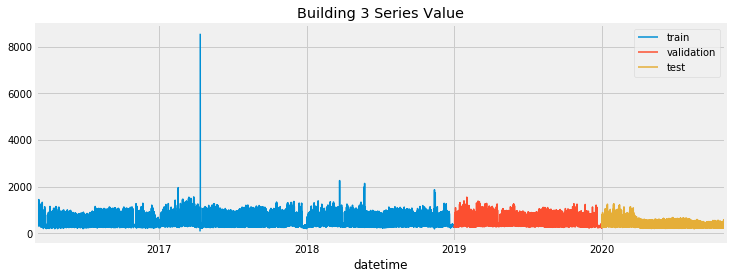

In [8]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
building3train['series_value'].plot(ax=ax, label='train')
building3val['series_value'].plot(ax=ax, label='validation')
building3test['series_value'].plot(ax=ax, label='test')
ax.set_title('Building 3 Series Value')
ax.legend();

In [11]:
building3=building3.dropna()

In [12]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-22 16:35:20 
Last fit date: None 
Skforecast version: 0.4.3 

In [13]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = building3.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(building3train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  33%|████████████▎                        | 4/12 [00:08<00:18,  2.32s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  25%|█████████▎                           | 3/12 [00:06<00:18,  2.04s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  33%|████████████▎                        | 4/12 [00:12<00:28,  3.61s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  42%|███████████████▍                     | 5/12 [00:15<00:24,  3.43s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:19<00:22,  3.83s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:21<00:15,  3.17s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:24<00:11,  2.96s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  83%|██████████████████████████████      | 10/12 [00:28<00:05,  2.66s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:30<00:02,  2.43s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  17%|██████▏                              | 2/12 [00:04<00:24,  2.46s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:26<00:08,  2.85s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  83%|██████████████████████████████      | 10/12 [00:30<00:06,  3.11s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  17%|██████▏                              | 2/12 [00:04<00:21,  2.17s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  25%|█████████▎                           | 3/12 [00:06<00:17,  1.96s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:14<00:15,  2.57s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  83%|██████████████████████████████      | 10/12 [00:22<00:04,  2.25s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:24<00:02,  2.14s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 24859
Number of observations used for backtesting: 8622
    Number of folds: 240
    Number of steps per fold: 36
    Last fold only includes 18 observations

Data partition in fold: 0
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-06 16:00:00 -- 2019-01-08 03:00:00
Data partition in fold: 1
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-08 04:00:00 -- 2019-01-09 15:00:00
Data partition in fold: 2
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-09 16:00:00 -- 2019-01-11 03:00:00
Data partition in fold: 3
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-11 04:00:00 -- 2019-01-12 15:00:00
Data partition in fold: 4
    Training:   2016-03-01 05:00:00 -- 2019-01-06 15:00:00
    Validation: 2019-01-12 16:00:00 -- 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

loop lags_grid: 100%|███████████████████████████████████████| 4/4 [02:05<00:00, 31.50s/it]
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 18184.45313315125



In [14]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

lags  \
35  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
34  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
33  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
32  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
22  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
29  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
27  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
20  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
23  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
21  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params        metric  \
35  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  18184.453133   
34  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  19148.692676   
33  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  19545.725189   
32  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  19824.997655   
22  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  20223.074091   
29  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  20502.455024   
27  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  21104.706708   
20  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  21667.062517   
23  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  22242.341226   
21  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  22795.014260   

    learning_rate  max_depth  n_estimators  
35           0.10       10.0         500.0  
34           0.10       10.0         100.0  
33           0.10        5.0         500.0  
32           0.10        5.0         100.0  
22           0.10       10.0         100.0  
29           0.01       10.0         500.0  
27           0.01        5.0         500.0  
20           0.10        5.0         100.0  
23           0.10       10.0         500.0  
21           0.10        5.0         500.0

In [16]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = building3['series_value'],
    initial_train_size = len(building3.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Backtest error: 39851.920643598954


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

In [17]:
# Predictions
# ==============================================================================
predictions

pred
72  255.541320
73  261.888026
74  272.065348
75  274.898192
76  277.784981
..         ...
78  605.200182
79  688.332034
80  848.535937
81  934.589496
82  974.450509

[7319 rows x 1 columns]

TypeError: index type not supported

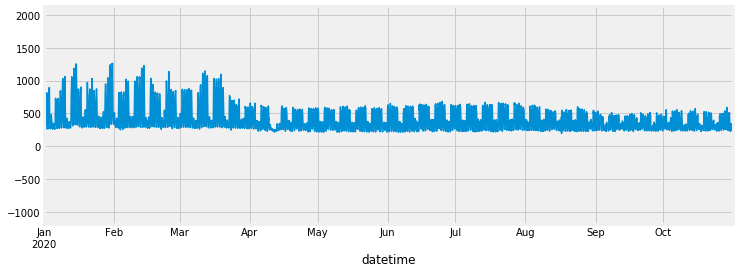

In [18]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
building3test['series_value'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

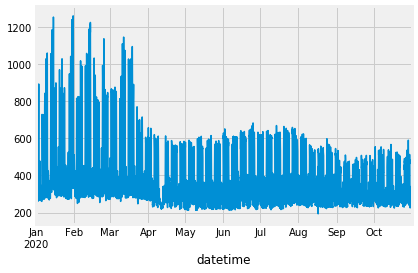

In [21]:
building3test['series_value'].plot()

In [22]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [30]:
building3test=building3test.dropna()
building3train=building3train.dropna()

In [39]:
mean_absolute_scaled_error(building3test.reset_index()['series_value'],predictions['pred'],building3train.reset_index()['series_value'])

4.2073940668243806